In [70]:
import pandas as pd
import os
import pyarrow as pd
from pyarrow import parquet as pq
from pyarrow import Table as table
from azure.identity import DefaultAzureCredential,InteractiveBrowserCredential
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Data,Model,PipelineJob
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml import Input, dsl,Output
import uuid
from IPython.display import HTML,display
import time

In [20]:
pip show azure-ai-ml

Name: azure-ai-ml
Version: 1.16.1
Summary: Microsoft Azure Machine Learning Client Library for Python
Home-page: https://github.com/Azure/azure-sdk-for-python
Author: Microsoft Corporation
Author-email: azuresdkengsysadmins@microsoft.com
License: MIT License
Location: /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages
Requires: azure-common, azure-core, azure-mgmt-core, azure-storage-blob, azure-storage-file-datalake, azure-storage-file-share, colorama, isodate, jsonschema, marshmallow, msrest, opencensus-ext-azure, opencensus-ext-logging, pydash, pyjwt, pyyaml, strictyaml, tqdm, typing-extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [15]:
dfTraining=pd.read_csv(filepath_or_buffer="train-data/diabetes.csv")
dfTest=pd.read_csv(filepath_or_buffer="test-data/diabetes-test.csv")

In [49]:
dfTraining.head()

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,0,171,80,34,23,43.509726,1.213191,21,0
1,8,92,93,47,36,21.240576,0.158365,23,0
2,7,115,47,52,35,41.511523,0.079019,23,0
3,9,103,78,25,304,29.582192,1.282870,43,1
4,1,85,59,27,35,42.604536,0.549542,22,0


In [17]:
tableTraining=table.from_pandas(df=dfTraining)
tableTest=table.from_pandas(df=dfTest)

In [18]:
tableTest

pyarrow.Table
Pregnancies: int64
PlasmaGlucose: int64
DiastolicBloodPressure: int64
TricepsThickness: int64
SerumInsulin: int64
BMI: double
DiabetesPedigree: double
Age: int64
Diabetic: int64
----
Pregnancies: [[1,0,8,3,8,...,10,2,0,0,3]]
PlasmaGlucose: [[78,116,171,108,153,...,65,73,93,132,114]]
DiastolicBloodPressure: [[41,92,42,63,99,...,60,66,89,98,65]]
TricepsThickness: [[33,16,29,45,15,...,46,27,43,18,47]]
SerumInsulin: [[311,184,160,297,41,...,177,168,57,161,512]]
BMI: [[50.79639151,18.60362975,35.48224692,49.37516891,35.06213922,...,33.51246773,30.13263576,18.69068305,19.7916451,36.21543653]]
DiabetesPedigree: [[0.420803683,0.131156495,0.082671083,0.100979095,0.116191245,...,0.14832658,0.862252262,0.427048955,0.302257208,0.14736285]]
Age: [[24,22,22,46,22,...,41,38,24,23,34]]
Diabetic: [[0,0,1,1,1,...,1,1,0,0,1]]

In [19]:
pq.write_table(table=tableTraining,where="train-data/diabetes-training.parquet",version="1.0")
pq.write_table(table=tableTest,where="test-data/diabetes-test.parquet",version="1.0")

In [22]:
try:
    credential=DefaultAzureCredential()
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    credential=InteractiveBrowserCredential()

In [23]:
mlClient=MLClient.from_config(credential=credential)

Found the config file in: /config.json


### Create Data Assets

In [27]:
trainDataPath="train-data/"
testDataPath="test-data"
dataVersion="1"

In [28]:
inputTrainDataAsset="diabetes_train_mltable"
inputTestDataAsset="diabetes_test_mltable"

In [32]:
try:
    # Try Getting data already registered in workspace
    trainData=mlClient.data.get(name=inputTrainDataAsset,version=dataVersion)
    testData=mlClient.data.get(name=inputTestDataAsset,version=dataVersion)
except Exception as e:
    trainData=Data(path=trainDataPath,type=AssetTypes.MLTABLE,
                  description="RAI Diabetes Training Data",name=inputTrainDataAsset,
                  version=dataVersion)
    mlClient.data.create_or_update(data=trainData)
    
    testData=Data(path=testDataPath,type=AssetTypes.MLTABLE,
                  description="RAI Diabetes Test Data",name=inputTestDataAsset,
                  version=dataVersion)
    mlClient.data.create_or_update(data=testData)
    # Register the Data Asset

Uploading train-data (0.7 MBs): 100%|██████████| 698594/698594 [00:00<00:00, 22830349.99it/s]


Uploading test-data (0.35 MBs): 100%|██████████| 353392/353392 [00:00<00:00, 8280772.75it/s]




### Build Pipeline to Create Responsible AI Dashboard

In [33]:
registryName="azureml"
mlClientRegistry=MLClient(
    credential=credential,
    subscription_id=mlClient.subscription_id,
    resource_group_name=mlClient.resource_group_name,
    registry_name=registryName
)
print(mlClientRegistry)

MLClient(credential=<azure.identity._credentials.default.DefaultAzureCredential object at 0x7f05715abfd0>,
         subscription_id=6c6683e9-e5fe-4038-8519-ce6ebec2ba15,
         resource_group_name=registry-builtin-prod-eastus-01,
         workspace_name=None)


### Register the Model

In [35]:
modelCreate=Model(
    name="local-mlflow-diabetes-model",
    path="model",
    type=AssetTypes.MLFLOW_MODEL,
    description="MLFlow Model Created from Local File"    
)

model=mlClient.models.create_or_update(model=modelCreate)

Uploading model (0.0 MBs): 100%|██████████| 2611/2611 [00:00<00:00, 48929.39it/s]




In [37]:
print(model)

creation_context:
  created_at: '2024-08-29T09:52:35.530597+00:00'
  created_by: Ritish Adhikari
  created_by_type: User
  last_modified_at: '2024-08-29T09:52:35.530597+00:00'
  last_modified_by: Ritish Adhikari
  last_modified_by_type: User
description: MLFlow Model Created from Local File
flavors:
  python_function:
    env: conda.yaml
    loader_module: mlflow.sklearn
    model_path: model.pkl
    predict_fn: predict
    python_version: 3.7.15
  sklearn:
    code: ''
    pickled_model: model.pkl
    serialization_format: cloudpickle
    sklearn_version: 0.24.1
id: azureml:/subscriptions/18a1f27f-edf5-495e-9acb-753c93335294/resourceGroups/rg-dp100-labs/providers/Microsoft.MachineLearningServices/workspaces/mlw-dp100-labs/models/local-mlflow-diabetes-model/versions/1
name: local-mlflow-diabetes-model
path: azureml://subscriptions/18a1f27f-edf5-495e-9acb-753c93335294/resourceGroups/rg-dp100-labs/workspaces/mlw-dp100-labs/datastores/workspaceblobstore/paths/LocalUpload/8830170daf18aeb10

### Build the Pipeline

In [36]:
modelName=model.name
expectedModelID=f"{modelName}:1"
azuremlModelID=f"azureml:{expectedModelID}"

print(modelName,expectedModelID,azuremlModelID)

local-mlflow-diabetes-model local-mlflow-diabetes-model:1 azureml:local-mlflow-diabetes-model:1


In [38]:
label="latest"

raiConstructerComponent=mlClientRegistry.components.get(
    name="microsoft_azureml_rai_tabular_insight_constructor",
    label=label
)
version=raiConstructerComponent.version
print(version)

0.15.0


In [39]:
raiErrorAnalysisComponent=mlClientRegistry.components.get(
    name="microsoft_azureml_rai_tabular_erroranalysis",
    version=version
)

raiExplainationComponent=mlClientRegistry.components.get(
    name="microsoft_azureml_rai_tabular_explanation",
    version=version
)

raiGatherComponent=mlClientRegistry.components.get(
    name="microsoft_azureml_rai_tabular_insight_gather",
    version=version
)

In [78]:
computeName="aml-cluster"

@dsl.pipeline(
    compute=computeName,
    description="Responsible Insights on Diabetes Data",
    experiment_name=f"RAI_insights_{modelName}"
)
def raiDecisionPipeline(
    targetColumnName,trainData, testData
    ):
    
    # Initiate RAIInsights
    create_rai_job=raiConstructerComponent(
        title="RAI dashboard diabetes",
        task_type="classification",
        model_info=expectedModelID,
        model_input=Input(type=AssetTypes.MLFLOW_MODEL,path=azuremlModelID),
        train_dataset=trainData,
        test_dataset=testData,
        target_column_name=targetColumnName
    )
    create_rai_job.set_limits(timeout=300)
    
    # Add error analysis
    error_job=raiErrorAnalysisComponent(
        rai_insights_dashboard=create_rai_job.outputs.rai_insights_dashboard
    )
    error_job.set_limits(timeout=300)
    
    # Add Explanations
    explanation_job=raiExplainationComponent(
        rai_insights_dashboard=create_rai_job.outputs.rai_insights_dashboard,
        comment="Explanation Component"
    )
    explanation_job.set_limits(timeout=300)
    
    # Combining Everything through Gather Component
    rai_gather_job=raiGatherComponent(
        constructor=create_rai_job.outputs.rai_insights_dashboard,
        insight_3=error_job.outputs.error_analysis,
        insight_4=explanation_job.outputs.explanation         
    )
    rai_gather_job.set_limits(timeout=300)
    
    rai_gather_job.outputs.dashboard.mode="upload"
    
    return {
        "dashboard": rai_gather_job.outputs.dashboard
    }
    

In [79]:
targetColumnName="Diabetic"

diabetesTrainPQ=Input(type=AssetTypes.MLTABLE,
                    path=f"azureml:{inputTrainDataAsset}:{dataVersion}",
                    mode="download"
)

diabetesTestPQ=Input(type=AssetTypes.MLTABLE,
                    path=f"azureml:{inputTestDataAsset}:{dataVersion}",
                    mode="download"
)

In [80]:
insightsPipelineJob=raiDecisionPipeline(targetColumnName=targetColumnName,
                                        trainData=diabetesTrainPQ,testData=diabetesTestPQ)


# Workaround to Enable the Download
insightsPipelineJob.outputs.dashboard=Output(
    path=f"azureml://datastores/workspaceblobstore/paths/{str(uuid.uuid4())}/dashboard",
    mode="upload",
    type="uri_folder"
)

### Run the Pipeline

In [81]:
def submitAndWait(mlClient,pipelineJob) -> PipelineJob:
    createdJob=mlClient.jobs.create_or_update(job=pipelineJob)
    assert createdJob
    
    print("Pipeline Job can be accessed from the below URL")
    print(createdJob.studio_url)
    
    while createdJob.status not in {"Completed","Failed","Cancelled","NotResponding"}:
        time.sleep(30)
        createdJob=mlClient.jobs.get(name=createdJob.name)
        print(f"Latest Status: {createdJob.status}")
    assert createdJob.status=="Completed"
    return createdJob

In [82]:
insightsJob=submitAndWait(mlClient=mlClient,pipelineJob=insightsPipelineJob)

pathOnCompute is not a known attribute of class <class 'azure.ai.ml._restclient.v2023_04_01_preview.models._models_py3.UriFolderJobOutput'> and will be ignored


Pipeline Job can be accessed from the below URL
https://ml.azure.com/runs/mango_comb_zdsh22zmc8?wsid=/subscriptions/18a1f27f-edf5-495e-9acb-753c93335294/resourcegroups/rg-dp100-labs/workspaces/mlw-dp100-labs&tid=6a1d2f96-8cdf-4d1a-943d-7b73f4dfbb6d
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Running
Latest Status: Completed


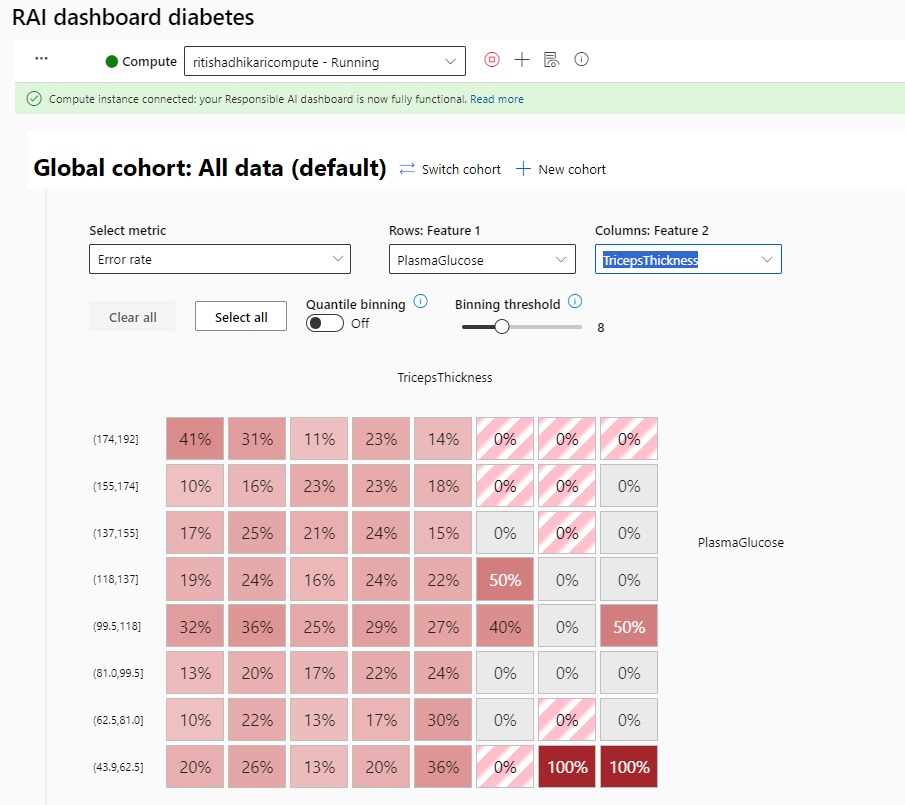

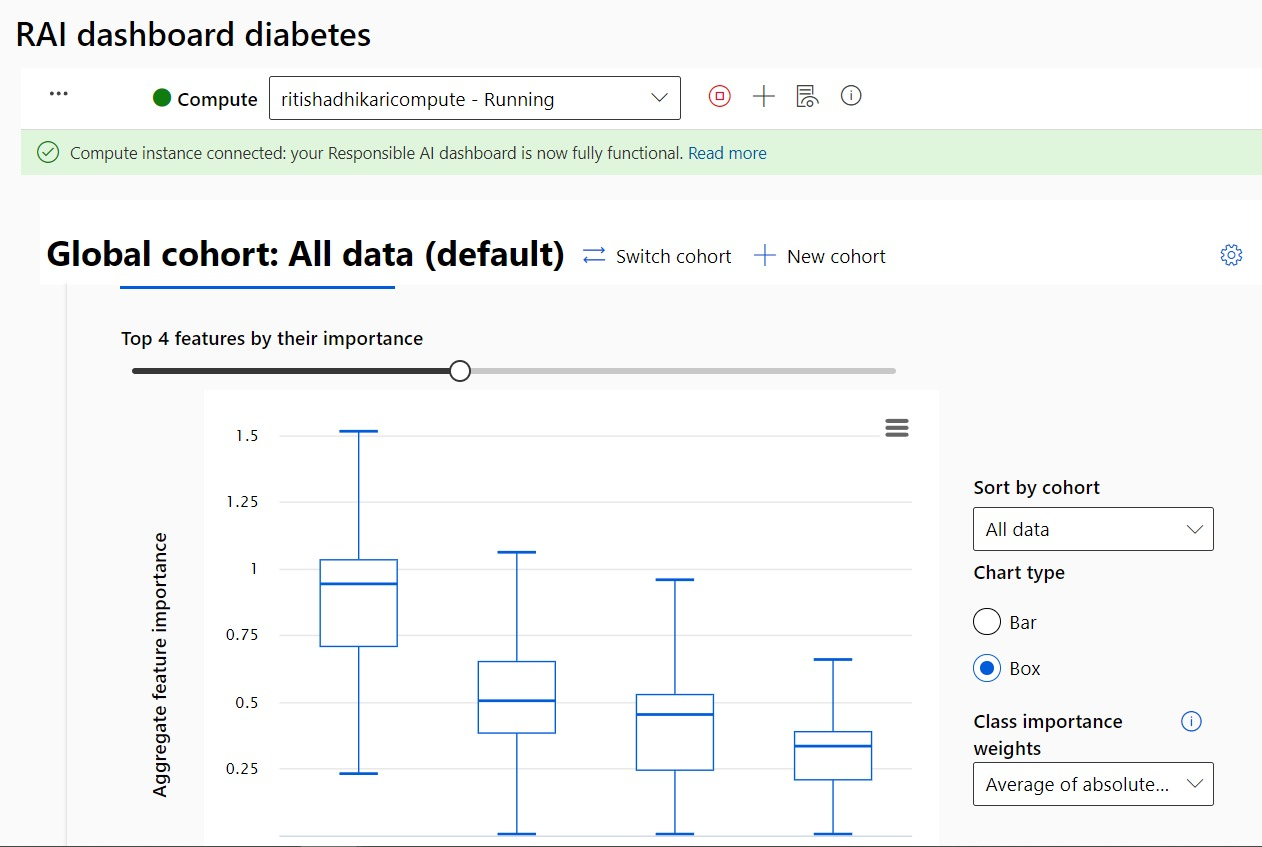

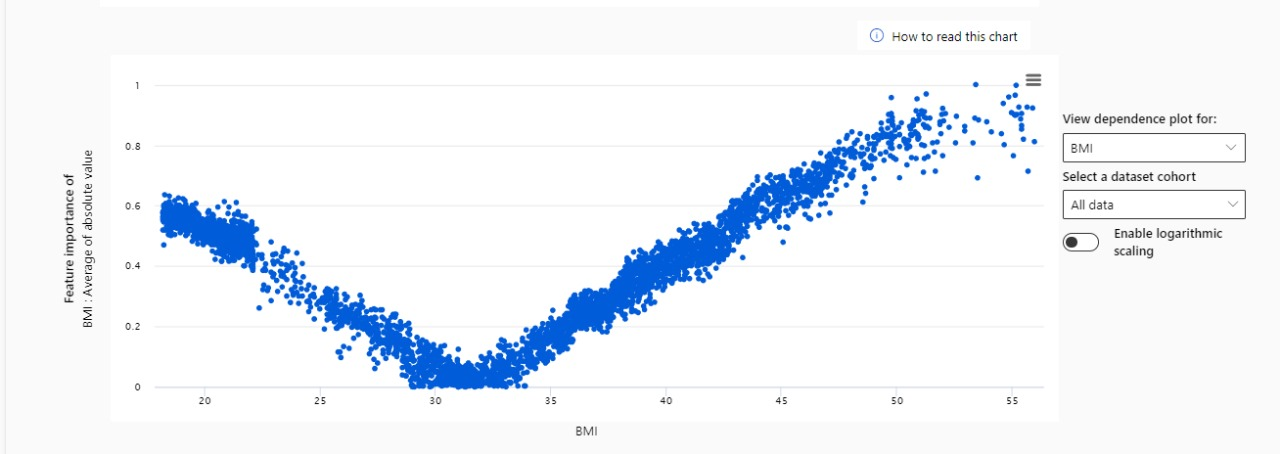

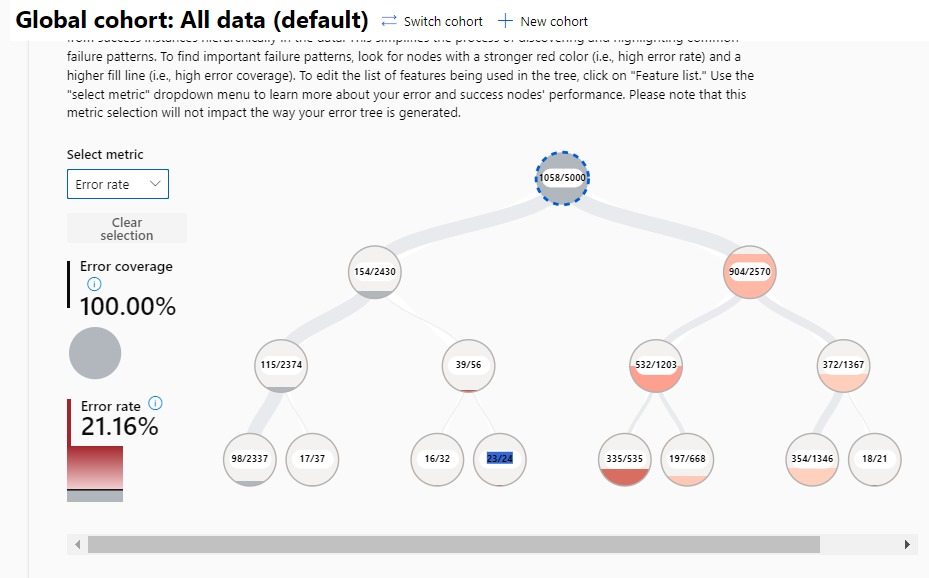